In [155]:
# Notebook Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import scipy.stats as stats
from scipy.stats import norm
from numpy.linalg import cholesky
import cvxpy as cp

# Set global plotting style
plt.style.use("ggplot")  # Alternative to seaborn-darkgrid
sns.set_palette("muted")
sns.set_context("notebook", font_scale=1.2)

# Set random seed for reproducibility
np.random.seed(42)

# Define the assets
assets = [
    "Government Bonds", "Investment-Grade Bonds", "High-Yield Bonds",
    "Emerging Market Gov. Bonds", "Equities (Developed Markets)",
    "Equities (Emerging Markets)", "Private Equity", "Infrastructure",
    "Real Estate", "Hedge Funds"
]

# Expected annual returns (converted to decimals)
expected_returns_annual = np.array([
    3.00, 3.40, 4.80, 4.70, 6.80, 8.40, 9.00, 6.60, 4.70, 5.00
]) / 100

# Annual volatilities (converted to decimals)
volatilities_annual = np.array([
    3.30, 5.70, 9.70, 9.30, 15.80, 20.80, 20.40, 14.60, 9.60, 9.20
]) / 100

# Annual investment costs (converted to decimals)
costs_annual = np.array([
    0.23, 0.33, 0.60, 0.44, 0.49, 0.71, 0.23, 0.23, 0.23, 0.23
]) / 100

# Correlation matrix (10x10)
correlation_matrix = np.array([
    [1.0,  0.6,  0.2,  0.4,  0.0,  0.0, -0.1, -0.1, -0.1,  0.0],
    [0.6,  1.0,  0.7,  0.6,  0.3,  0.3,  0.2,  0.1,  0.1,  0.3],
    [0.2,  0.7,  1.0,  0.7,  0.7,  0.6,  0.5,  0.4,  0.3,  0.6],
    [0.4,  0.6,  0.7,  1.0,  0.5,  0.7,  0.3,  0.2,  0.2,  0.5],
    [0.0,  0.3,  0.7,  0.5,  1.0,  0.7,  0.7,  0.4,  0.4,  0.7],
    [0.0,  0.3,  0.6,  0.7,  0.7,  1.0,  0.6,  0.4,  0.3,  0.7],
    [-0.1, 0.2,  0.5,  0.3,  0.7,  0.6,  1.0,  0.5,  0.4,  0.6],
    [-0.1, 0.1,  0.4,  0.2,  0.4,  0.4,  0.5,  1.0,  0.3,  0.3],
    [-0.1, 0.1,  0.3,  0.2,  0.4,  0.3,  0.4,  0.3,  1.0,  0.3],
    [0.0,  0.3,  0.6,  0.5,  0.7,  0.7,  0.6,  0.3,  0.3,  1.0]
])

print(" Libraries loaded and data initialized.")

 Libraries loaded and data initialized.


In [157]:
# Number of weeks per year
weeks_per_year = 52

# Convert expected returns and costs to weekly values
expected_returns_weekly = (1 + expected_returns_annual) ** (1 / weeks_per_year) - 1
costs_weekly = costs_annual / weeks_per_year

# Convert volatilities to weekly values
volatilities_weekly = volatilities_annual / np.sqrt(weeks_per_year)

# Compute covariance matrix from correlation matrix
covariance_matrix_weekly = np.outer(volatilities_weekly, volatilities_weekly) * correlation_matrix
covariance_matrix_annual = np.outer(volatilities_annual, volatilities_annual) * correlation_matrix

# Store processed data in a dictionary
data_summary = {
    "Expected Returns (Annual)": expected_returns_annual,
    "Expected Returns (Weekly)": expected_returns_weekly,
    "Volatility (Annual)": volatilities_annual,
    "Volatility (Weekly)": volatilities_weekly,
    "Costs (Annual)": costs_annual,
    "Costs (Weekly)": costs_weekly,
}

# Convert dictionary to DataFrame for easy display
df_data_summary = pd.DataFrame(data_summary, index=assets)

# Display processed data
display(df_data_summary) 

,Expected Returns (Annual),Expected Returns (Weekly),Volatility (Annual),Volatility (Weekly),Costs (Annual),Costs (Weekly)
Government Bonds,0.030,0.000569,0.033,0.004576,0.0023,0.000044
Investment-Grade Bonds,0.034,0.000643,0.057,0.007904,0.0033,0.000063
High-Yield Bonds,0.048,0.000902,0.097,0.013451,0.0060,0.000115
Emerging Market Gov. Bonds,0.047,0.000884,0.093,0.012897,0.0044,0.000085
Equities (Developed Markets),0.068,0.001266,0.158,0.021911,0.0049,0.000094
Equities (Emerging Markets),0.084,0.001552,0.208,0.028844,0.0071,0.000137
Private Equity,0.090,0.001659,0.204,0.028290,0.0023,0.000044
Infrastructure,0.066,0.001230,0.146,0.020247,0.0023,0.000044
Real Estate,0.047,0.000884,0.096,0.013313,0.0023,0.000044
Hedge Funds,0.050,0.000939,0.092,0.012758,0.0023,0.000044


In [159]:
# ----------------------------------------------
# Monte Carlo Simulation of Weekly Prices
# ----------------------------------------------

# Simulation parameters
num_weeks = weeks_per_year * 5  # 5 years
num_simulations = 10_000  # Monte Carlo paths
num_assets = len(assets)

# Initial asset prices (normalized to 1)
initial_prices = np.ones(num_assets)

# Generate correlated random returns using Cholesky decomposition
cholesky_matrix = cholesky(covariance_matrix_weekly)
random_shocks = np.random.normal(size=(num_simulations, num_weeks, num_assets))
correlated_shocks = random_shocks @ cholesky_matrix.T

# Simulate price evolution using log-normal returns
price_paths = np.zeros((num_simulations, num_weeks + 1, num_assets))
price_paths[:, 0, :] = initial_prices

for t in range(1, num_weeks + 1):
    log_returns = expected_returns_weekly - (costs_weekly + (volatilities_weekly ** 2) / 2) + correlated_shocks[:, t - 1, :]
    price_paths[:, t, :] = price_paths[:, t - 1, :] * np.exp(log_returns)  # Log-normal price simulation

# Compute After-Cost Linear Returns
linear_returns_after_cost = price_paths[:, 1:, :] - 1 - costs_weekly  # R_t' = S_t - 1 - cost_weekly

print("Monte Carlo simulation completed.")
print("After-cost linear returns computed.")

Monte Carlo simulation completed.
After-cost linear returns computed.


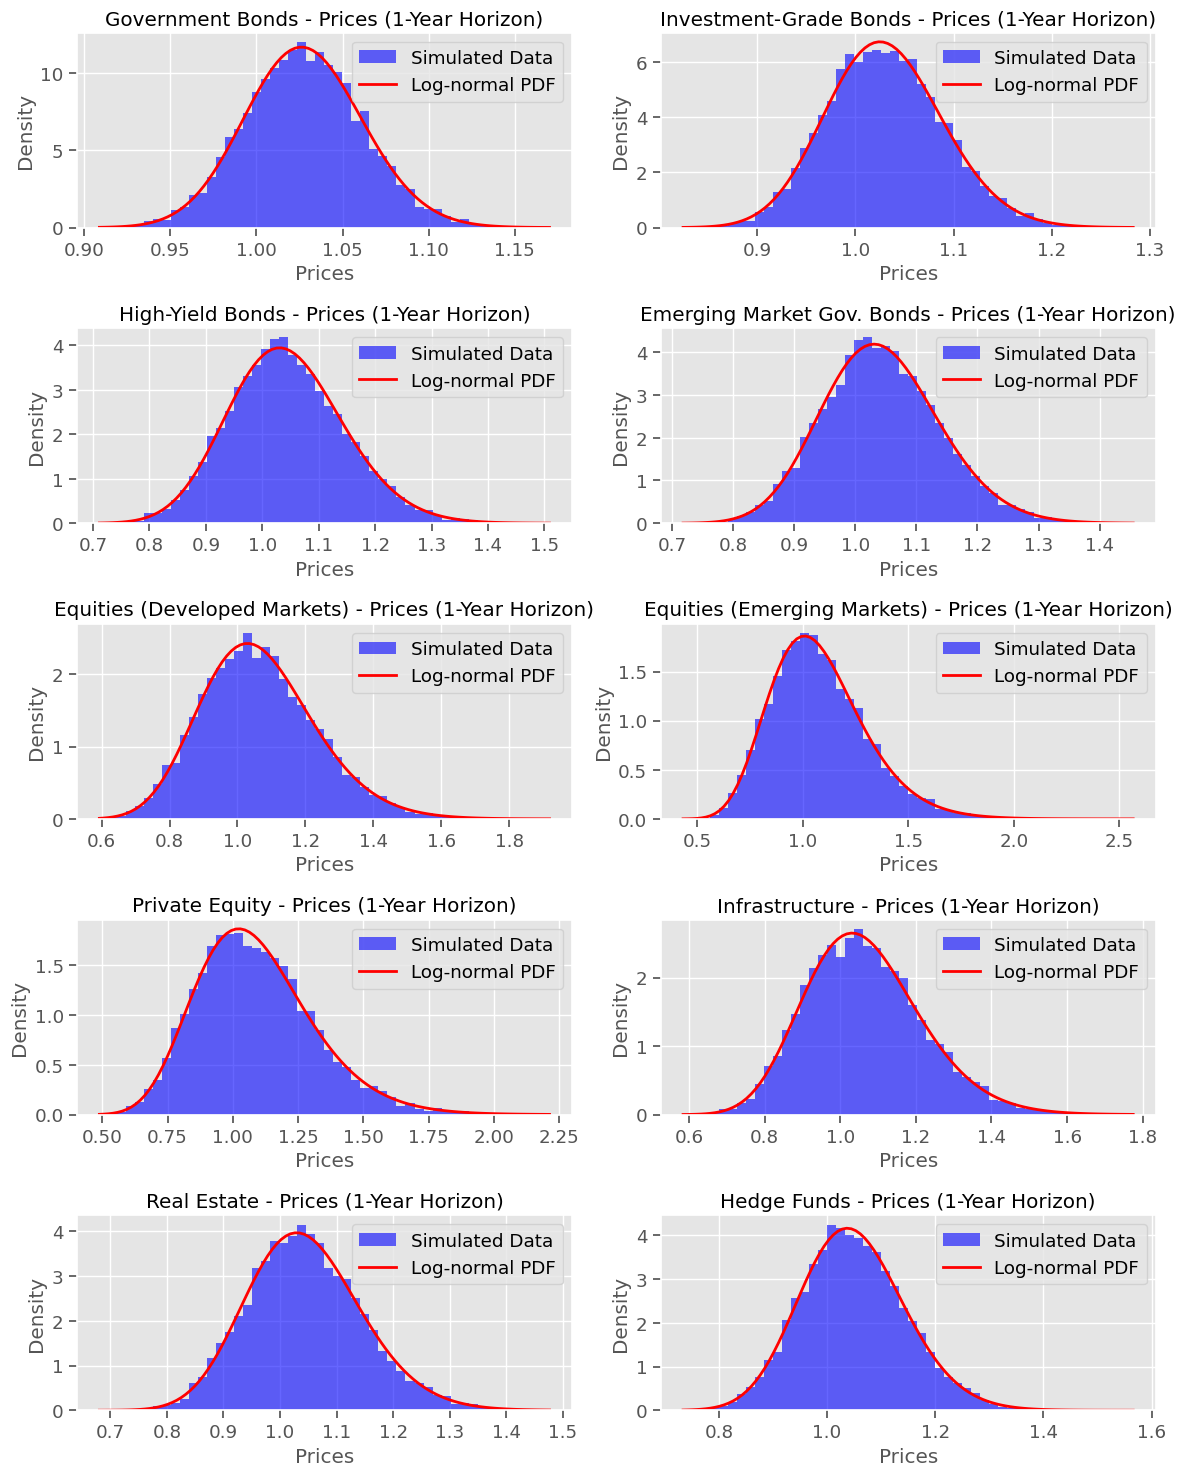

 Prices Distributions Plotted for 1-Year Horizon.


/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


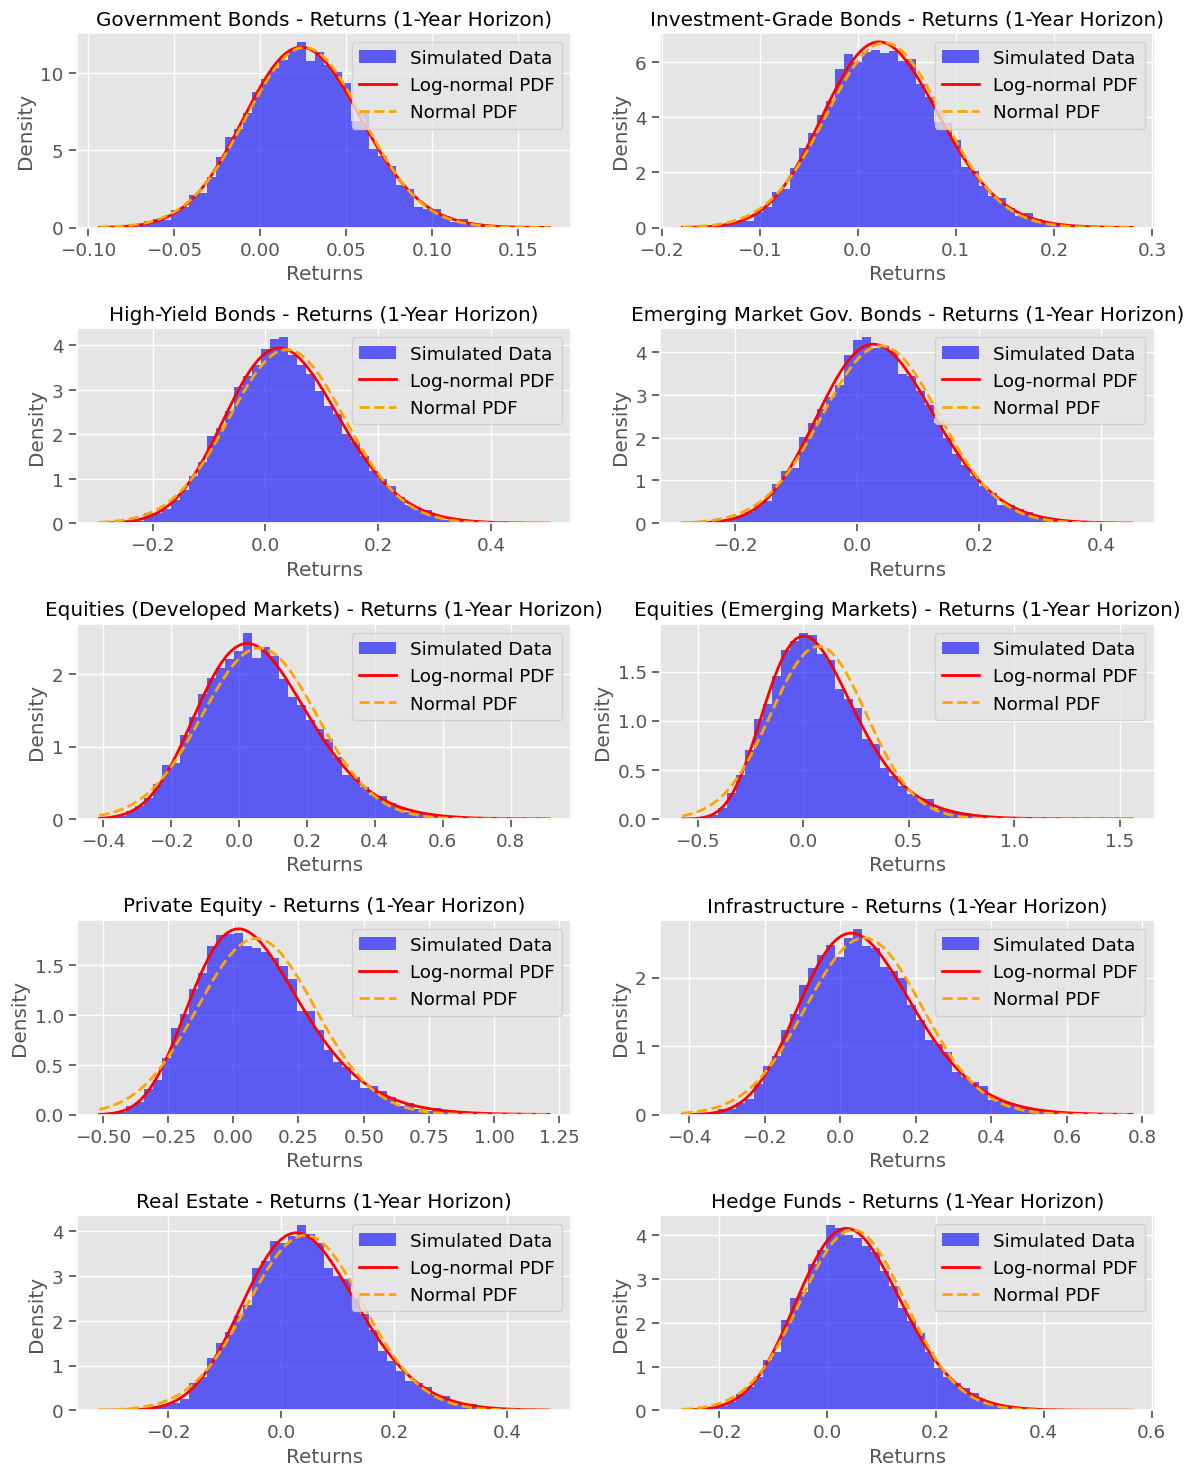

 Returns Distributions Plotted for 1-Year Horizon.


In [163]:
from scipy.stats import lognorm, norm

def plot_distributions(data, distribution_type, horizon):
    """
    Plots histograms + PDFs for both after-cost prices & after-cost linear returns.
    - `data`: The data to plot (either prices or returns)
    - `distribution_type`: "Prices" or "Returns"
    - `horizon`: Time horizon in years (e.g., 1-year or 5-year)
    """
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))  # 5 rows, 2 columns

    for i, ax in enumerate(axes.flatten()[:num_assets]):  # Loop over each asset
        asset_data = data[:, i]  # Extract data for asset `i`
        
        # Histogram of Simulated Data
        ax.hist(asset_data, bins=50, density=True, alpha=0.6, color='blue', label="Simulated Data")

        # Fit Log-normal distribution (for Prices & Returns)
        shape, loc, scale = lognorm.fit(asset_data)
        x = np.linspace(min(asset_data), max(asset_data), 100)
        lognorm_pdf = lognorm.pdf(x, shape, loc, scale)
        ax.plot(x, lognorm_pdf, linestyle="solid", linewidth=2, color="red", label="Log-normal PDF")

        # Fit Normal distribution (for Returns only)
        if distribution_type == "Returns":
            mu, std = np.mean(asset_data), np.std(asset_data)
            normal_pdf = norm.pdf(x, mu, std)
            ax.plot(x, normal_pdf, linestyle="dashed", linewidth=2, color="orange", label="Normal PDF")

        # Labels and Formatting
        ax.set_title(f"{assets[i]} - {distribution_type} ({horizon}-Year Horizon)")
        ax.set_xlabel(distribution_type)
        ax.set_ylabel("Density")
        ax.legend()

    plt.tight_layout()
    plt.show()
    print(f" {distribution_type} Distributions Plotted for {horizon}-Year Horizon.")

# ----------------------------------------------
# 1. Compute Theoretical After-Cost Price & Return Distributions BEFORE Simulation
# ----------------------------------------------

#  Compute after-cost expected returns
mu_prime = expected_returns_annual - costs_annual  # After-cost expected return

#  Compute after-cost price distribution (Log-normal)
theoretical_after_cost_prices = np.exp(np.random.normal(mu_prime - 0.5 * volatilities_annual**2, volatilities_annual, size=(num_simulations, num_assets)))

#  Compute after-cost linear return distribution (Log-normal & Normal)
theoretical_after_cost_linear_returns = theoretical_after_cost_prices - 1 - costs_annual  # Linear return = S_t - 1 - costs

#  Plot Histograms & PDFs for Initial After-Cost Prices & Returns
plot_distributions(theoretical_after_cost_prices, distribution_type="Prices", horizon=1)
plot_distributions(theoretical_after_cost_linear_returns, distribution_type="Returns", horizon=1)

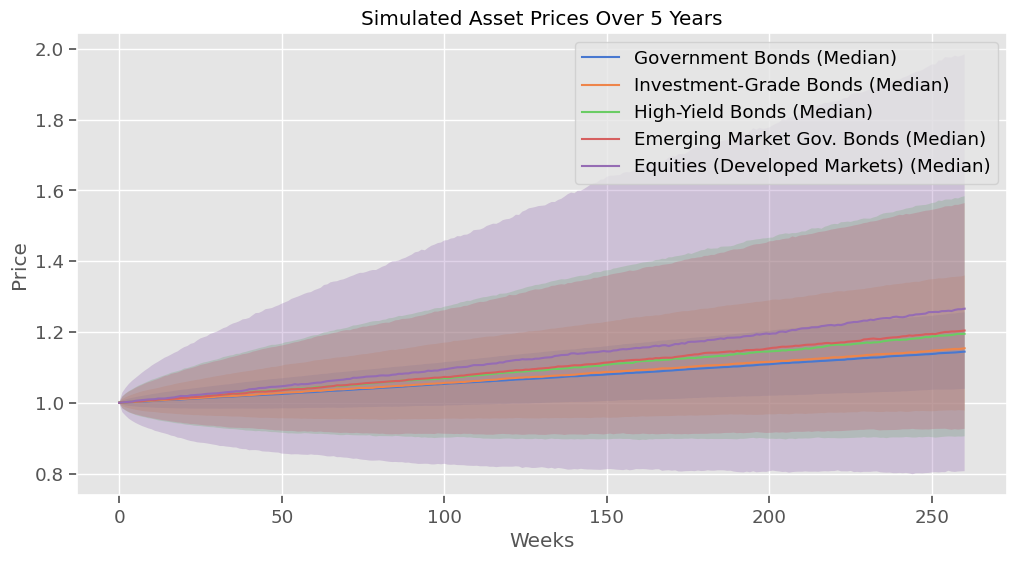

 Price Evolution Plotted.


In [165]:

# Compute median and percentiles for visualization
median_prices = np.median(price_paths, axis=0)
p10_prices = np.percentile(price_paths, 10, axis=0)
p90_prices = np.percentile(price_paths, 90, axis=0)

# Plot the evolution of some selected assets
plt.figure(figsize=(12, 6))

for i in range(min(5, num_assets)):  # Plot first 5 assets for readability
    plt.plot(median_prices[:, i], label=f"{assets[i]} (Median)")
    plt.fill_between(range(num_weeks + 1), p10_prices[:, i], p90_prices[:, i], alpha=0.3)

plt.xlabel("Weeks")
plt.ylabel("Price")
plt.title("Simulated Asset Prices Over 5 Years")
plt.legend()
plt.show()

print(" Price Evolution Plotted.")

In [167]:
# Choose percentiles for validation
percentiles_to_check = [10, 25, 50, 75, 90]  

# Compute theoretical log-normal percentiles
T = num_weeks / weeks_per_year  # Time horizon in years
Z_values = norm.ppf(np.array(percentiles_to_check) / 100)  # Standard normal quantiles

analytical_percentiles = np.zeros((len(percentiles_to_check), num_assets))

for i in range(num_assets):
    mu_adj = expected_returns_annual[i] - (costs_annual[i] + 0.5 * volatilities_annual[i] ** 2)
    analytical_percentiles[:, i] = initial_prices[i] * np.exp(mu_adj * T + volatilities_annual[i] * np.sqrt(T) * Z_values)

# Extract corresponding simulated percentiles
simulated_percentiles = np.percentile(price_paths[:, -1, :], percentiles_to_check, axis=0)

print(" Computed Theoretical vs. Simulated Percentiles.")

 Computed Theoretical vs. Simulated Percentiles.


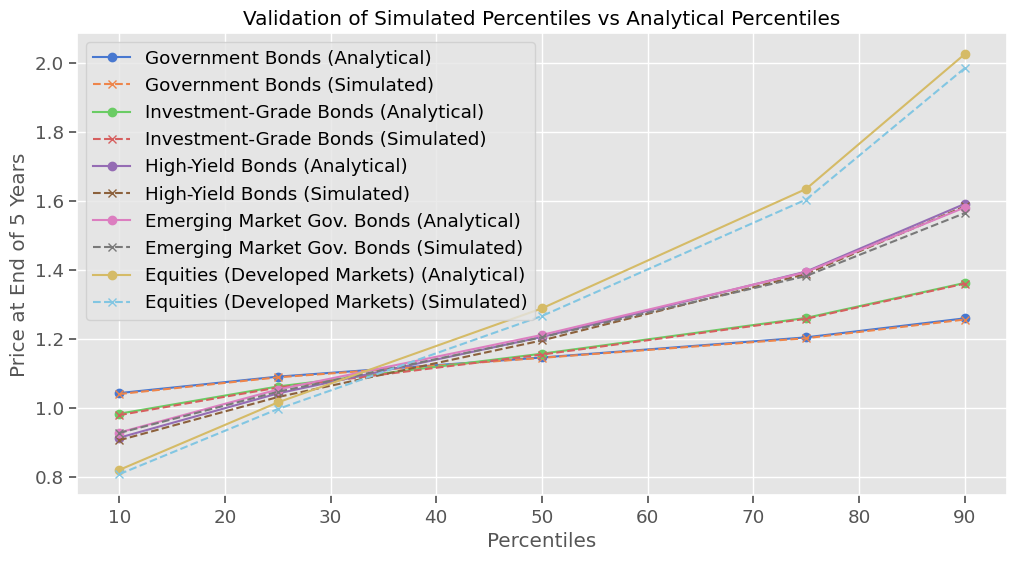

✅ Percentile Validation Plot Created.


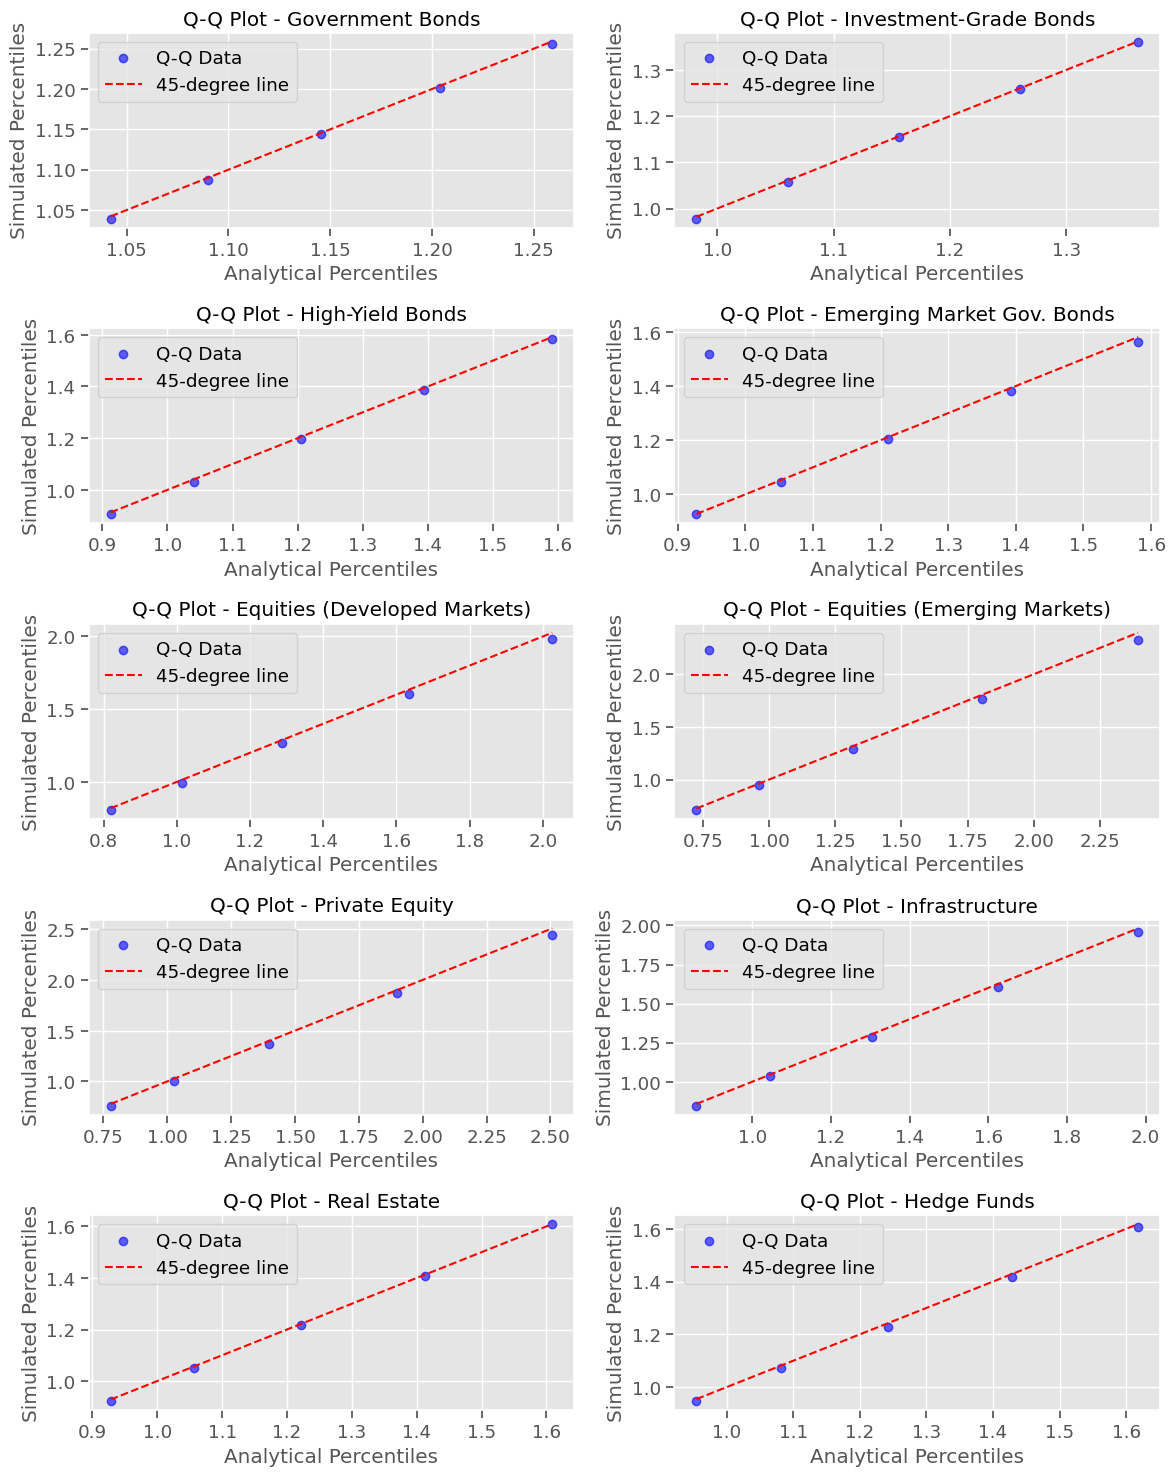

✅ Q-Q Plots Generated


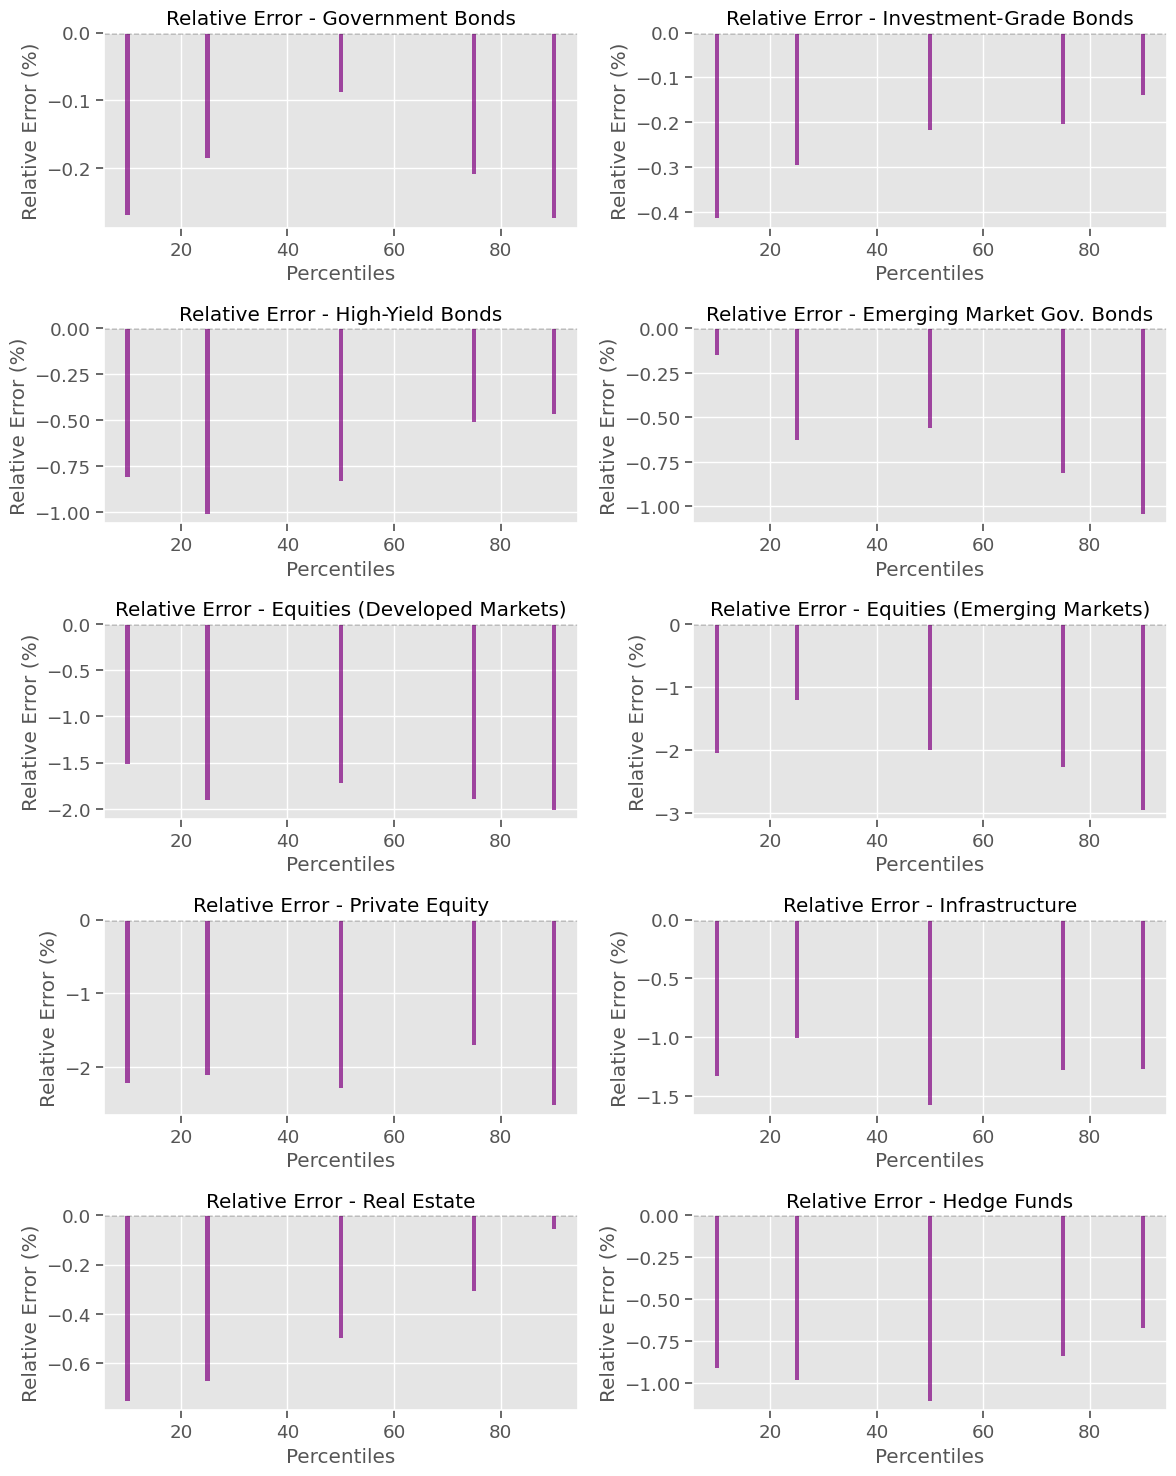

✅ Relative Error Bar Plots Generated


In [169]:

plt.figure(figsize=(12, 6))

for i in range(min(5, num_assets)):  # Plot first 5 assets for readability
    plt.plot(percentiles_to_check, analytical_percentiles[:, i], marker="o", linestyle="-", label=f"{assets[i]} (Analytical)")
    plt.plot(percentiles_to_check, simulated_percentiles[:, i], marker="x", linestyle="--", label=f"{assets[i]} (Simulated)")

plt.xlabel("Percentiles")
plt.ylabel("Price at End of 5 Years")
plt.title("Validation of Simulated Percentiles vs Analytical Percentiles")
plt.legend()
plt.grid(True)
plt.show()

print("Percentile Validation Plot Created.")

# Quantile-Quantile (Q-Q) Plot Function
def plot_qq(simulated, analytical, asset_names):
    num_assets = len(asset_names)
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))
    
    for i, ax in enumerate(axes.flatten()[:num_assets]):
        # Q-Q plot data
        sorted_simulated = np.sort(simulated[:, i])
        sorted_analytical = np.sort(analytical[:, i])
        
        # Plot Q-Q
        ax.scatter(sorted_analytical, sorted_simulated, color="blue", alpha=0.6, label="Q-Q Data")
        ax.plot([min(sorted_analytical), max(sorted_analytical)], 
                [min(sorted_analytical), max(sorted_analytical)], 
                linestyle="dashed", color="red", label="45-degree line")

        # Labels & Formatting
        ax.set_title(f"Q-Q Plot - {asset_names[i]}")
        ax.set_xlabel("Analytical Percentiles")
        ax.set_ylabel("Simulated Percentiles")
        ax.legend()

    plt.tight_layout()
    plt.show()
    print("Q-Q Plots Generated")

# Relative Error Bar Plot Function
def plot_relative_error(simulated, analytical, percentiles, asset_names):
    num_assets = len(asset_names)
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 15))

    for i, ax in enumerate(axes.flatten()[:num_assets]):
        relative_errors = (simulated[:, i] - analytical[:, i]) / analytical[:, i] * 100
        
        # Bar plot for relative errors
        ax.bar(percentiles, relative_errors, color="purple", alpha=0.7)
        
        # Labels & Formatting
        ax.set_title(f"Relative Error - {asset_names[i]}")
        ax.set_xlabel("Percentiles")
        ax.set_ylabel("Relative Error (%)")
        ax.axhline(y=0, color="black", linestyle="dashed", linewidth=1)  # Baseline
        ax.grid(True)

    plt.tight_layout()
    plt.show()
    print("Relative Error Bar Plots Generated")

# Generate the Updated Plots
plot_qq(simulated_percentiles, analytical_percentiles, assets)  # Q-Q Plot
plot_relative_error(simulated_percentiles, analytical_percentiles, percentiles_to_check, assets)  # Relative Error Plot

In [171]:

def debug_shape(name, array):
    print(f"DEBUG: {name} shape: {np.shape(array)}")  # Should be (10,)


def ensure_1d(array):
    """Convert 2D arrays to 1D if needed."""
    if len(array.shape) > 1:
        return np.mean(array, axis=0)  # Reduce to (10,)
    return array

# Define functions for risk metrics
def calculate_volatility(returns):
    return ensure_1d(np.std(returns, axis=0))

def calculate_var(returns, confidence_level=0.95):
    return ensure_1d(np.percentile(returns, 100 * (1 - confidence_level), axis=0))

def calculate_cvar(returns, confidence_level=0.95):
    """Compute Conditional Value at Risk (CVaR) correctly."""
    var_threshold = calculate_var(returns, confidence_level)  # Ensure it's (10,)

    # Ensure correct axis for calculations
    num_assets = returns.shape[2]  # Should be 10
    cvar_values = np.zeros(num_assets)  # Initialize array for CVaR values per asset

    for i in range(num_assets):
        asset_returns = returns[:, :, i].flatten()  # Flatten all time points
        tail_losses = asset_returns[asset_returns <= var_threshold[i]]

        if tail_losses.size > 0:
            cvar_values[i] = np.mean(tail_losses)  # Compute CVaR
        else:
            cvar_values[i] = var_threshold[i]  # Default to VaR if no values are below it

    return cvar_values  # Should be (10,)

def calculate_max_drawdown(prices):
    cumulative_max = np.maximum.accumulate(prices, axis=1)
    drawdowns = (prices - cumulative_max) / cumulative_max
    return ensure_1d(np.min(drawdowns, axis=1))  # Ensure 1D output

def calculate_sharpe_ratio(returns):
    return ensure_1d(np.mean(returns, axis=0) / np.std(returns, axis=0))

# Compute Risk Measures Using After-Cost Linear Returns
weekly_volatility = calculate_volatility(linear_returns_after_cost)  # FIXED
weekly_var = calculate_var(linear_returns_after_cost)  # FIXED
weekly_cvar = calculate_cvar(linear_returns_after_cost)  # FIXED
weekly_mdd = calculate_max_drawdown(price_paths[:, 1:, :])  # Unchanged
weekly_sharpe = calculate_sharpe_ratio(linear_returns_after_cost)  # FIXED

yearly_volatility = calculate_volatility(linear_returns_after_cost[:, ::weeks_per_year, :])  # FIXED
yearly_var = calculate_var(linear_returns_after_cost[:, ::weeks_per_year, :])  # FIXED
yearly_cvar = calculate_cvar(linear_returns_after_cost[:, ::weeks_per_year, :])  # FIXED
yearly_mdd = calculate_max_drawdown(price_paths[:, -weeks_per_year:, :])  # Unchanged
yearly_sharpe = calculate_sharpe_ratio(linear_returns_after_cost[:, ::weeks_per_year, :])  # FIXED

# Debugging: Print shapes to verify correctness
debug_shape("weekly_volatility", weekly_volatility)
debug_shape("weekly_var", weekly_var)
debug_shape("weekly_cvar", weekly_cvar)
debug_shape("weekly_mdd", weekly_mdd)
debug_shape("weekly_sharpe", weekly_sharpe)

debug_shape("yearly_volatility", yearly_volatility)
debug_shape("yearly_var", yearly_var)
debug_shape("yearly_cvar", yearly_cvar)
debug_shape("yearly_mdd", yearly_mdd)
debug_shape("yearly_sharpe", yearly_sharpe)

# Organize into DataFrames
weekly_risk_df = pd.DataFrame({
    "Volatility (σ)": weekly_volatility,
    "VaR 95%": weekly_var,
    "CVaR 95%": weekly_cvar,
    "Max Drawdown": weekly_mdd,
    "Sharpe Ratio": weekly_sharpe
}, index=assets)

yearly_risk_df = pd.DataFrame({
    "Volatility (σ)": yearly_volatility,
    "VaR 95%": yearly_var,
    "CVaR 95%": yearly_cvar,
    "Max Drawdown": yearly_mdd,
    "Sharpe Ratio": yearly_sharpe
}, index=assets)

print(" Individual Asset Risk Measures Computed.")

# Display DataFrames
print("\n Weekly Risk Measures")
display(weekly_risk_df)

print("\n Yearly Risk Measures")
display(yearly_risk_df)

print("Risk Measure Tables Displayed.")

DEBUG: weekly_volatility shape: (10,)
DEBUG: weekly_var shape: (10,)
DEBUG: weekly_cvar shape: (10,)
DEBUG: weekly_mdd shape: (10,)
DEBUG: weekly_sharpe shape: (10,)
DEBUG: yearly_volatility shape: (10,)
DEBUG: yearly_var shape: (10,)
DEBUG: yearly_cvar shape: (10,)
DEBUG: yearly_mdd shape: (10,)
DEBUG: yearly_sharpe shape: (10,)
 Individual Asset Risk Measures Computed.

 Weekly Risk Measures


,Volatility (σ),VaR 95%,CVaR 95%,Max Drawdown,Sharpe Ratio
Government Bonds,0.053551,-0.014126,-0.032124,-0.049111,1.181705
Investment-Grade Bonds,0.093969,-0.066345,-0.101179,-0.098650,0.751070
High-Yield Bonds,0.166069,-0.137418,-0.194679,-0.174566,0.582829
Emerging Market Gov. Bonds,0.157725,-0.124231,-0.179061,-0.163990,0.622403
Equities (Developed Markets),0.291692,-0.236113,-0.322064,-0.276086,0.507569
Equities (Emerging Markets),0.401683,-0.314116,-0.411887,-0.353097,0.458026
Private Equity,0.406594,-0.289570,-0.386282,-0.338625,0.528233
Infrastructure,0.266228,-0.207300,-0.285611,-0.251780,0.565371
Real Estate,0.165674,-0.130224,-0.187929,-0.168661,0.636928
Hedge Funds,0.158711,-0.114032,-0.167640,-0.157767,0.697435



 Yearly Risk Measures


,Volatility (σ),VaR 95%,CVaR 95%,Max Drawdown,Sharpe Ratio
Government Bonds,0.044889,-0.014641,-0.034269,-0.026305,0.999491
Investment-Grade Bonds,0.078578,-0.058571,-0.094129,-0.049916,0.635703
High-Yield Bonds,0.138272,-0.119515,-0.176683,-0.086684,0.493244
Emerging Market Gov. Bonds,0.131331,-0.107445,-0.162001,-0.082175,0.527712
Equities (Developed Markets),0.241522,-0.204353,-0.291414,-0.139965,0.430985
Equities (Emerging Markets),0.330786,-0.271141,-0.373378,-0.182022,0.389893
Private Equity,0.332942,-0.250086,-0.349302,-0.176606,0.450381
Infrastructure,0.220194,-0.179411,-0.259789,-0.128935,0.482686
Real Estate,0.137956,-0.113407,-0.171257,-0.084885,0.540624
Hedge Funds,0.132163,-0.100547,-0.153941,-0.080534,0.592786


Risk Measure Tables Displayed.


In [173]:
import numpy as np
import cvxpy as cp

# Number of assets
num_assets = len(assets)

# Convert expected returns and covariance matrix to annual values
mu = expected_returns_annual  # Expected returns (annualized)
Sigma = covariance_matrix_annual  # Covariance matrix (annualized)

# Target returns for MVO
target_returns = np.array([0.035, 0.045, 0.065])  # 3.5%, 4.5%, 6.5%

# Equally Weighted Portfolio (EW)
weights_eq = np.ones(num_assets) / num_assets

# Minimum Variance Portfolio (MVP)
w_mvp = cp.Variable(num_assets)  # Asset weights (decision variable)
objective_mvp = cp.Minimize(cp.quad_form(w_mvp, Sigma))  # Minimize variance
constraints_mvp = [cp.sum(w_mvp) == 1, w_mvp >= 0]  # Budget + No short-selling
problem_mvp = cp.Problem(objective_mvp, constraints_mvp)
problem_mvp.solve()
weights_mvp = w_mvp.value  # Optimized weights

#Mean-Variance Portfolios with Target Returns
weights_mvo = {}

for target in target_returns:
    w_mvo = cp.Variable(num_assets)  # Asset weights (decision variable)
    expected_return = mu @ w_mvo  # Portfolio expected return
    objective_mvo = cp.Minimize(cp.quad_form(w_mvo, Sigma))  # Minimize variance
    constraints_mvo = [cp.sum(w_mvo) == 1, w_mvo >= 0, expected_return >= target]  # Constraints
    problem_mvo = cp.Problem(objective_mvo, constraints_mvo)
    problem_mvo.solve()
    weights_mvo[f"Target Return {target * 100:.1f}%"] = w_mvo.value  # Store weights

# Store all portfolios in a dictionary
portfolios = {
    "Equally Weighted": weights_eq,
    "Minimum Variance": weights_mvp,
    "Target Return 3.5%": weights_mvo["Target Return 3.5%"],
    "Target Return 4.5%": weights_mvo["Target Return 4.5%"],
    "Target Return 6.5%": weights_mvo["Target Return 6.5%"],
}

# Convert to DataFrame for display
df_portfolios = pd.DataFrame(portfolios, index=assets)
display(df_portfolios)


,Equally Weighted,Minimum Variance,Target Return 3.5%,Target Return 4.5%,Target Return 6.5%
Government Bonds,0.1,8.216949e-01,7.741059e-01,5.672610e-01,7.279502e-02
Investment-Grade Bonds,0.1,-3.994921e-21,-4.922613e-22,-4.729292e-21,1.186711e-21
High-Yield Bonds,0.1,1.945200e-22,7.446449e-23,-6.237462e-22,-2.228180e-21
Emerging Market Gov. Bonds,0.1,-1.559889e-21,7.604734e-23,-4.337897e-21,1.747653e-01
Equities (Developed Markets),0.1,5.945062e-21,1.177477e-21,2.767743e-21,-1.474099e-22
Equities (Emerging Markets),0.1,8.231866e-21,1.621210e-21,3.908240e-02,9.821278e-02
Private Equity,0.1,7.936497e-21,1.670639e-21,8.676750e-02,2.539345e-01
Infrastructure,0.1,2.970174e-02,4.856773e-02,1.189658e-01,2.465504e-01
Real Estate,0.1,9.039388e-02,9.832198e-02,1.192449e-01,1.537419e-01
Hedge Funds,0.1,5.820947e-02,7.900440e-02,6.867842e-02,2.337494e-21


In [177]:
def compute_portfolio_metrics(weights, mean_returns, cov_matrix):
    """Compute portfolio risk metrics using annualized expected discrete returns."""
    
    # Portfolio Expected Return
    port_return = np.dot(weights, mean_returns)

    # Portfolio Standard Deviation & Variance
    port_std = np.sqrt(weights.T @ cov_matrix @ weights)  
    port_variance = port_std ** 2

    # Sharpe Ratio (Risk-Free Rate = 0)
    sharpe_ratio = port_return / port_std if port_std != 0 else np.nan

    # Compute VaR & CVaR using normal assumptions on **linear returns**
    var_95 = port_return - 1.645 * port_std  
    cvar_95 = port_return - 2.062 * port_std  

    # Estimate Maximum Drawdown using normal tail estimation
    max_drawdown = -2.33 * port_std  

    return port_return, port_std, port_variance, sharpe_ratio, var_95, cvar_95, max_drawdown

# Compute ANNUAL risk metrics
portfolio_metrics_annual = {
    name: compute_portfolio_metrics(weights, expected_returns_annual, covariance_matrix_annual)
    for name, weights in portfolios.items()
}

# Convert to DataFrame
portfolio_metrics_annual_df = pd.DataFrame(
    portfolio_metrics_annual,
    index=["Return", "Volatility", "Variance", "Sharpe Ratio", "VaR 95%", "CVaR 95%", "Max Drawdown"]
)

# Display annual portfolio risk measures
display(portfolio_metrics_annual_df.T)
print("Annual Portfolio Risk Metrics Computed & Displayed")


def convert_to_weekly(portfolio_metrics_annual_df):
    """Convert annual risk metrics to weekly equivalents using proper transformations."""
    converted_metrics = portfolio_metrics_annual_df.copy()
    
    # Convert Expected Return using compounding
    converted_metrics.loc["Return"] = (1 + converted_metrics.loc["Return"]) ** (1 / 52) - 1
    
    # Convert Volatility and Variance using sqrt(52)
    converted_metrics.loc["Volatility"] /= np.sqrt(52)
    converted_metrics.loc["Variance"] /= 52
    
    # Convert Sharpe Ratio accordingly
    converted_metrics.loc["Sharpe Ratio"] *= np.sqrt(52)
    
    # Convert VaR & CVaR using sqrt(52)
    converted_metrics.loc["VaR 95%"] /= np.sqrt(52)
    converted_metrics.loc["CVaR 95%"] /= np.sqrt(52)

    # Convert Max Drawdown using sqrt(52)
    converted_metrics.loc["Max Drawdown"] /= np.sqrt(52)

    return converted_metrics

# Compute WEEKLY risk metrics
portfolio_metrics_weekly_df = convert_to_weekly(portfolio_metrics_annual_df)

# Display weekly portfolio risk measures
display(portfolio_metrics_weekly_df.T)
print(" Weekly Portfolio Risk Metrics Summary:")

,Return,Volatility,Variance,Sharpe Ratio,VaR 95%,CVaR 95%,Max Drawdown
Equally Weighted,0.05640,0.085656,0.007337,0.658451,-0.084503,-0.120222,-0.199577
Minimum Variance,0.03377,0.029187,0.000852,1.157029,-0.014242,-0.026413,-0.068006
Target Return 3.5%,0.03500,0.029539,0.000873,1.184863,-0.013592,-0.025910,-0.068827
Target Return 4.5%,0.04500,0.047686,0.002274,0.943669,-0.033444,-0.053329,-0.111109
Target Return 6.5%,0.06500,0.104883,0.011000,0.619737,-0.107533,-0.151269,-0.244378


Annual Portfolio Risk Metrics Computed & Displayed


,Return,Volatility,Variance,Sharpe Ratio,VaR 95%,CVaR 95%,Max Drawdown
Equally Weighted,0.001056,0.011878,0.000141,4.748161,-0.011719,-0.016672,-0.027676
Minimum Variance,0.000639,0.004048,0.000016,8.343452,-0.001975,-0.003663,-0.009431
Target Return 3.5%,0.000662,0.004096,0.000017,8.544171,-0.001885,-0.003593,-0.009545
Target Return 4.5%,0.000847,0.006613,0.000044,6.804896,-0.004638,-0.007395,-0.015408
Target Return 6.5%,0.001212,0.014545,0.000212,4.468990,-0.014912,-0.020977,-0.033889


 Weekly Portfolio Risk Metrics Summary:


In [205]:
def compute_asset_contributions(weights, mean_returns, cov_matrix, portfolio_cvar):
    """Compute individual asset contributions to risk, return, and tail risk."""
    portfolio_std = np.sqrt(weights.T @ cov_matrix @ weights)  # Portfolio Volatility
    
    # **Marginal Contribution to Risk (MCTR)**
    mctr = (cov_matrix @ weights) / portfolio_std  

    # **2Risk Contribution (RC)**
    risk_contribution = weights * mctr  

    # **3CVaR Contribution (Component CVaR)**
    cvar_contribution = weights * portfolio_cvar  # Using portfolio CVaR

    # **4Contribution to Portfolio Expected Return**
    return_contribution = weights * mean_returns  

    return mctr, risk_contribution, cvar_contribution, return_contribution

# Compute contributions for all portfolios
portfolio_contributions = {
    name: compute_asset_contributions(weights, expected_returns_annual, covariance_matrix_annual, portfolio_metrics_annual[name][5])
    for name, weights in portfolios.items()
}

# Convert to DataFrame and format numbers properly
columns = ["MCTR", "Risk Contribution", "CVaR Contribution", "Return Contribution"]
portfolio_contributions_df = {
    name: pd.DataFrame(np.vstack(values).T, index=assets, columns=columns)
    for name, values in portfolio_contributions.items()
}

# Apply formatting to remove scientific notation
for portfolio_name, df in portfolio_contributions_df.items():
    df = df.map(lambda x: f"{x:.6f}")  # Format all values to 6 decimal places
    print(f"\n {portfolio_name} Portfolio Contributions:")
    display(df)
    print("\n" + "-"*50 + "\n")

print(" Asset Contributions Displayed with Proper Formatting (No Scientific Notation)")


 Equally Weighted Portfolio Contributions:


,MCTR,Risk Contribution,CVaR Contribution,Return Contribution
Government Bonds,0.003051,0.000305,-0.012022,0.003000
Investment-Grade Bonds,0.026811,0.002681,-0.012022,0.003400
High-Yield Bonds,0.077957,0.007796,-0.012022,0.004800
Emerging Market Gov. Bonds,0.063896,0.006390,-0.012022,0.004700
Equities (Developed Markets),0.136334,0.013633,-0.012022,0.006800
Equities (Emerging Markets),0.177997,0.017800,-0.012022,0.008400
Private Equity,0.164452,0.016445,-0.012022,0.009000
Infrastructure,0.087032,0.008703,-0.012022,0.006600
Real Estate,0.047599,0.004760,-0.012022,0.004700
Hedge Funds,0.071426,0.007143,-0.012022,0.005000



--------------------------------------------------


 Minimum Variance Portfolio Contributions:


,MCTR,Risk Contribution,CVaR Contribution,Return Contribution
Government Bonds,0.029187,0.023983,-0.021704,0.024651
Investment-Grade Bonds,0.037452,-0.000000,0.000000,-0.000000
High-Yield Bonds,0.043119,0.000000,-0.000000,0.000000
Emerging Market Gov. Bonds,0.051386,-0.000000,0.000000,-0.000000
Equities (Developed Markets),0.048474,0.000000,-0.000000,0.000000
Equities (Emerging Markets),0.057629,0.000000,-0.000000,0.000000
Private Equity,0.042921,0.000000,-0.000000,0.000000
Infrastructure,0.029187,0.000867,-0.000785,0.001960
Real Estate,0.029187,0.002638,-0.002388,0.004249
Hedge Funds,0.029187,0.001699,-0.001538,0.002910



--------------------------------------------------


 Target Return 3.5% Portfolio Contributions:


,MCTR,Risk Contribution,CVaR Contribution,Return Contribution
Government Bonds,0.026692,0.020662,-0.020057,0.023223
Investment-Grade Bonds,0.036973,-0.000000,0.000000,-0.000000
High-Yield Bonds,0.049710,0.000000,-0.000000,0.000000
Emerging Market Gov. Bonds,0.054021,0.000000,-0.000000,0.000000
Equities (Developed Markets),0.062580,0.000000,-0.000000,0.000000
Equities (Emerging Markets),0.075737,0.000000,-0.000000,0.000000
Private Equity,0.063035,0.000000,-0.000000,0.000000
Infrastructure,0.047194,0.002292,-0.001258,0.003205
Real Estate,0.036373,0.003576,-0.002548,0.004621
Hedge Funds,0.038082,0.003009,-0.002047,0.003950



--------------------------------------------------


 Target Return 4.5% Portfolio Contributions:


,MCTR,Risk Contribution,CVaR Contribution,Return Contribution
Government Bonds,0.009735,0.005522,-0.030251,0.017018
Investment-Grade Bonds,0.026282,-0.000000,0.000000,-0.000000
High-Yield Bonds,0.064369,-0.000000,0.000000,-0.000000
Emerging Market Gov. Bonds,0.053458,-0.000000,0.000000,-0.000000
Equities (Developed Markets),0.112754,0.000000,-0.000000,0.000000
Equities (Emerging Markets),0.146358,0.005720,-0.002084,0.003283
Private Equity,0.161539,0.014016,-0.004627,0.007809
Infrastructure,0.100817,0.011994,-0.006344,0.007852
Real Estate,0.052746,0.006290,-0.006359,0.005605
Hedge Funds,0.060336,0.004144,-0.003663,0.003434



--------------------------------------------------


 Target Return 6.5% Portfolio Contributions:


,MCTR,Risk Contribution,CVaR Contribution,Return Contribution
Government Bonds,-0.000425,-0.000031,-0.011012,0.002184
Investment-Grade Bonds,0.017803,0.000000,-0.000000,0.000000
High-Yield Bonds,0.063668,-0.000000,0.000000,-0.000000
Emerging Market Gov. Bonds,0.050724,0.008865,-0.026437,0.008214
Equities (Developed Markets),0.118994,-0.000000,0.000000,-0.000000
Equities (Emerging Markets),0.162051,0.015915,-0.014857,0.008250
Private Equity,0.180104,0.045735,-0.038412,0.022854
Infrastructure,0.107892,0.026601,-0.037295,0.016272
Real Estate,0.050724,0.007798,-0.023256,0.007226
Hedge Funds,0.060292,0.000000,-0.000000,0.000000



--------------------------------------------------

 Asset Contributions Displayed with Proper Formatting (No Scientific Notation)


In [195]:
def mean_variance_portfolio_cvxpy(target_return, mean_returns, cov_matrix):
    """Computes the Mean-Variance Portfolio for a target return using CVXPY
       and extracts the Lagrange multipliers from the constraints."""
    
    num_assets = len(mean_returns)
    weights = cp.Variable(num_assets)

    # Objective: Minimize portfolio variance
    portfolio_variance = cp.quad_form(weights, cov_matrix)
    objective = cp.Minimize(portfolio_variance)

    # Constraints
    budget_constraint = cp.sum(weights) == 1  # Fully invested constraint
    long_only_constraints = weights >= 0  # No short selling
    return_constraint = cp.matmul(weights, mean_returns) == target_return  # Target return constraint

    constraints = [budget_constraint, long_only_constraints, return_constraint]

    # Solve problem
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.CLARABEL, verbose=False)
    
    # Extract dual values (Lagrange multipliers)
    lagrange_multipliers = {
        "Budget Constraint": budget_constraint.dual_value if budget_constraint.dual_value is not None else 0,
        "Return Constraint": return_constraint.dual_value if return_constraint.dual_value is not None else 0,
        "Long-Only Constraints": long_only_constraints.dual_value if long_only_constraints.dual_value is not None else np.zeros(num_assets)
    }

    return weights.value, lagrange_multipliers, problem  # Also return problem instance


In [197]:
# Portfolio target returns
target_returns = [0.035, 0.045, 0.065]  # 3.5%, 4.5%, 6.5%
portfolio_names = ["Target Return 3.5%", "Target Return 4.5%", "Target Return 6.5%"]

# Initialize storage for results
portfolio_weights = {}
portfolio_problems = {}
lagrange_results = []

for name, target in zip(portfolio_names, target_returns):
    weights, multipliers, problem = mean_variance_portfolio_cvxpy(target, expected_returns_annual, covariance_matrix_annual)
    portfolio_weights[name] = weights
    portfolio_problems[name] = problem  # Store the problem instance
    lagrange_results.append({"Portfolio": name, **multipliers})


In [199]:
# Define asset names
asset_names = [
    "Government Bonds",
    "Investment-Grade Bonds",
    "High-Yield Bonds",
    "Emerging Market Gov. Bonds",
    "Equities (Developed Markets)",
    "Equities (Emerging Markets)",
    "Private Equity",
    "Infrastructure",
    "Real Estate",
    "Hedge Funds"
]

# Function to format and display Lagrange multipliers properly
def display_lagrange_multipliers(portfolio_name, lagrange_multipliers):
    """Formats and displays Lagrange multipliers for a portfolio with asset names."""
    
    # Convert to DataFrame for display
    formatted_data = {
        "Constraint": ["Budget Constraint", "Return Constraint"] + asset_names,
        "Multiplier": [lagrange_multipliers["Budget Constraint"], 
                       lagrange_multipliers["Return Constraint"]] + 
                      list(lagrange_multipliers["Long-Only Constraints"])
    }

    df = pd.DataFrame(formatted_data)
    
    # Display the table
    print(f" **Lagrange Multipliers for {portfolio_name}**")
    display(df)

# Apply function to each portfolio
for name, multipliers in zip(["Target Return 3.5%", "Target Return 4.5%", "Target Return 6.5%"], lagrange_results):
    display_lagrange_multipliers(name, multipliers)


 **Lagrange Multipliers for Target Return 3.5%**


,Constraint,Multiplier
0,Budget Constraint,-5.675709e-04
1,Return Constraint,-3.364477e-02
2,Government Bonds,1.146024e-10
3,Investment-Grade Bonds,4.728460e-04
4,High-Yield Bonds,7.542805e-04
5,Emerging Market Gov. Bonds,1.042578e-03
6,Equities (Developed Markets),8.417238e-04
7,Equities (Emerging Markets),1.080712e-03
8,Private Equity,1.284806e-04
9,Infrastructure,1.215320e-09


 **Lagrange Multipliers for Target Return 4.5%**


,Constraint,Multiplier
0,Budget Constraint,6.310435e-03
1,Return Constraint,-2.412974e-01
2,Government Bonds,6.989978e-11
3,Investment-Grade Bonds,6.129473e-04
4,High-Yield Bonds,8.672351e-04
5,Emerging Market Gov. Bonds,6.792492e-05
6,Equities (Developed Markets),6.557875e-04
7,Equities (Emerging Markets),8.530748e-10
8,Private Equity,6.546157e-10
9,Infrastructure,5.012651e-10


 **Lagrange Multipliers for Target Return 6.5%**


,Constraint,Multiplier
0,Budget Constraint,1.902371e-02
1,Return Constraint,-6.311486e-01
2,Government Bonds,1.148262e-10
3,Investment-Grade Bonds,1.299051e-03
4,High-Yield Bonds,2.083983e-03
5,Emerging Market Gov. Bonds,2.875227e-10
6,Equities (Developed Markets),1.066602e-03
7,Equities (Emerging Markets),2.880604e-10
8,Private Equity,8.261585e-11
9,Infrastructure,9.849556e-11


In [201]:
# Extract expected return and CVaR from the computed metrics
risk_return_ratios = {
    name: portfolio_metrics_annual_df.loc["Return", name] / abs(portfolio_metrics_annual_df.loc["CVaR 95%", name])
    for name in portfolios.keys()
}

# Determine which portfolios meet the requirement
meets_requirement = {name: ratio >= 0.9 for name, ratio in risk_return_ratios.items()}

# Store results in a DataFrame
risk_return_df = pd.DataFrame({
    "Risk-Return Ratio": risk_return_ratios,
    "Meets Requirement": meets_requirement
})

# Display results
display(risk_return_df)

print(" Risk-Return Requirement Assessment Completed")

,Risk-Return Ratio,Meets Requirement
Equally Weighted,0.469133,False
Minimum Variance,1.278525,True
Target Return 3.5%,1.350831,True
Target Return 4.5%,0.843819,False
Target Return 6.5%,0.429698,False


 Risk-Return Requirement Assessment Completed


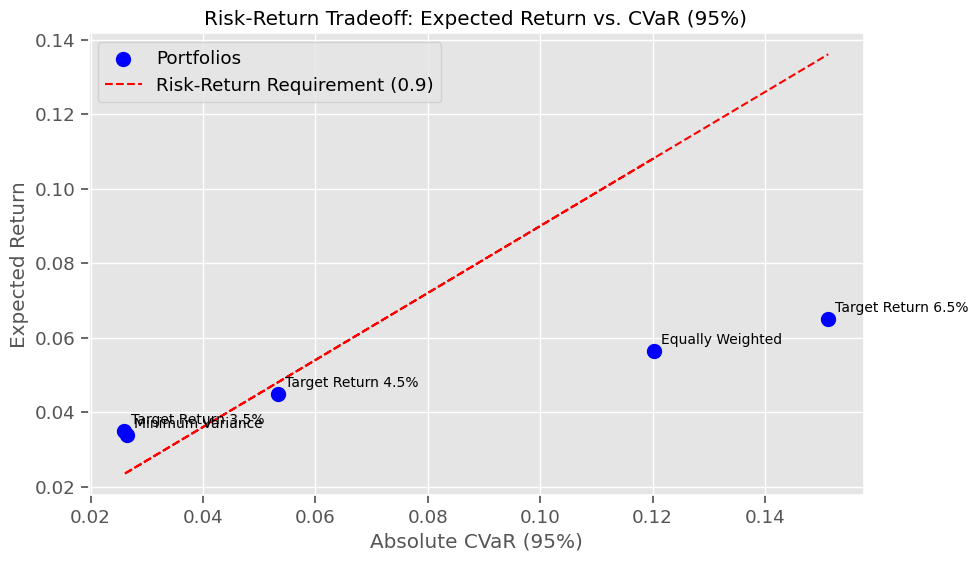

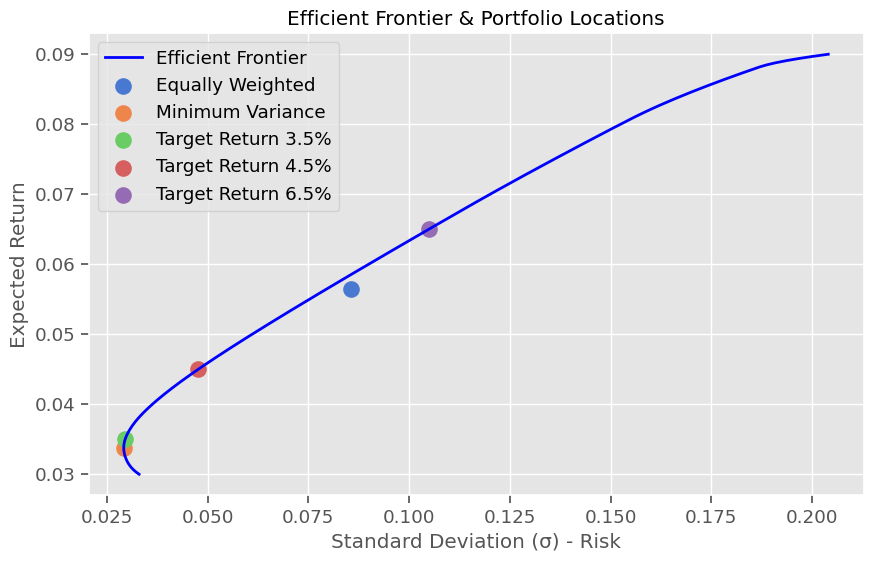

In [203]:
# Define target returns range for the Efficient Frontier (Annual)
target_returns_range = np.linspace(min(expected_returns_annual), max(expected_returns_annual), 200)

# Initialize storage for standard deviations and valid returns
frontier_std_devs = []
valid_target_returns = []

# Function to compute Minimum-Variance Portfolio for each return level
for target_return in target_returns_range:
    num_assets = len(expected_returns_annual)
    weights = cp.Variable(num_assets)

    # Objective: Minimize Portfolio Variance
    portfolio_variance = cp.quad_form(weights, covariance_matrix_annual)
    objective = cp.Minimize(portfolio_variance)

    # Constraints
    constraints = [
        cp.sum(weights) == 1,  # Fully invested
        weights >= 0,          # Long-only constraint
        cp.matmul(weights, expected_returns_annual) == target_return  # Expected return constraint
    ]

    # Solve Optimization Problem
    problem = cp.Problem(objective, constraints)
    result = problem.solve(solver=cp.CLARABEL, verbose=False)

    # If optimization is successful, store results
    if weights.value is not None:
        portfolio_std = np.sqrt(weights.value.T @ covariance_matrix_annual @ weights.value)  # Compute volatility
        frontier_std_devs.append(portfolio_std)
        valid_target_returns.append(target_return)

# Convert to NumPy Arrays
frontier_std_devs = np.array(frontier_std_devs)
valid_target_returns = np.array(valid_target_returns)

# Extract portfolio names
portfolio_names = list(portfolios.keys())

#  Extract portfolio risk & return metrics
expected_returns = portfolio_metrics_annual_df.loc["Return"].values
cvar_95 = np.abs(portfolio_metrics_annual_df.loc["CVaR 95%"].values)  # Absolute CVaR to ensure positive values
volatility = portfolio_metrics_annual_df.loc["Volatility"].values

# Risk-Return Requirement Threshold
risk_return_threshold = 0.9  # Investor's requirement
threshold_expected_returns = risk_return_threshold * cvar_95  # Correct threshold line calculation

# **1 Risk-Return Tradeoff Scatter Plot**
plt.figure(figsize=(10, 6))

# Scatter plot of portfolios
plt.scatter(cvar_95, expected_returns, color='blue', s=100, label="Portfolios")

# Risk-Return Threshold Line (Dynamically calculated)
plt.plot(cvar_95, threshold_expected_returns, linestyle="dashed", color="red", label="Risk-Return Requirement (0.9)")

# Annotate portfolio points
for i, txt in enumerate(portfolio_names):
    plt.annotate(txt, (cvar_95[i], expected_returns[i]), fontsize=10, xytext=(5, 5), textcoords="offset points")

plt.xlabel("Absolute CVaR (95%)")
plt.ylabel("Expected Return")
plt.title("Risk-Return Tradeoff: Expected Return vs. CVaR (95%)")
plt.legend()
plt.grid(True)
plt.show()

# ** Efficient Frontier Visualization**
plt.figure(figsize=(10, 6))

# Plot the Efficient Frontier
plt.plot(frontier_std_devs, valid_target_returns, linestyle="-", linewidth=2, color="blue", label="Efficient Frontier")

# Plot Candidate Portfolios
for i, label in enumerate(portfolio_names):
    plt.scatter(volatility[i], expected_returns[i], marker="o", s=120, label=label)

# Labels & Titles
plt.xlabel("Standard Deviation (σ) - Risk")
plt.ylabel("Expected Return")
plt.title("Efficient Frontier & Portfolio Locations")
plt.legend()
plt.grid(True)
plt.show()

In [151]:
# Set simulation parameters
num_simulations = 10000  # Number of Monte Carlo simulations
num_weeks = 52 * 5  # 5 years of weekly returns

# Extract portfolio parameters for MV (3.5%)
expected_weekly_return = (1 + portfolio_metrics_weekly_df.loc["Return", "Target Return 3.5%"])  # Convert to weekly compounding
weekly_volatility = portfolio_metrics_weekly_df.loc["Volatility", "Target Return 3.5%"]  # Weekly volatility
weekly_cvar_95 = portfolio_metrics_weekly_df.loc["CVaR 95%", "Target Return 3.5%"]  # Weekly CVaR
weekly_var_95 = portfolio_metrics_weekly_df.loc["VaR 95%", "Target Return 3.5%"]  # Weekly VaR

# Simulate portfolio returns assuming log-normal returns (Normal log returns)
simulated_returns = np.random.normal(
    loc=np.log(expected_weekly_return),  # Convert expected return to log-normal space
    scale=weekly_volatility,  # Use weekly volatility
    size=(num_weeks, num_simulations)
)

# Convert log returns back to linear
simulated_portfolio_values = np.exp(simulated_returns)

# Compute cumulative returns over the 5-year period
cumulative_returns = simulated_portfolio_values.cumprod(axis=0)

# Compute realized 5-year arithmetic returns
realized_arithmetic_returns = cumulative_returns[-1, :] - 1  # Final portfolio value minus 1

# Compute realized 5-year geometric returns
realized_geometric_returns = cumulative_returns[-1, :] ** (1 / (5)) - 1  # Convert to annualized geometric mean return

# Compute realized 5-year Sharpe Ratios (Risk-free rate = 0)
realized_sharpe_ratios = realized_arithmetic_returns / (weekly_volatility * np.sqrt(52 * 5))

# Store simulated risk metrics over time
simulated_volatility = np.std(simulated_returns, axis=0)  # Weekly volatility per simulation
simulated_var_95 = np.percentile(simulated_returns, 5, axis=0)  # 5% Value-at-Risk
simulated_cvar_95 = np.mean(simulated_returns[simulated_returns <= simulated_var_95], axis=0)  # Conditional VaR


simulation_results = {
    "Realized Arithmetic Returns": realized_arithmetic_returns,
    "Realized Geometric Returns": realized_geometric_returns,
    "Realized Sharpe Ratios": realized_sharpe_ratios,
    "Simulated Weekly Volatility": simulated_volatility,
    "Simulated Weekly VaR (95%)": simulated_var_95,
    "Simulated Weekly CVaR (95%)": simulated_cvar_95
}

print("Monte Carlo Simulation for 5-Year Portfolio Risk Measures Completed")

Monte Carlo Simulation for 5-Year Portfolio Risk Measures Completed


📊 Summary Statistics for 5-Year Monte Carlo Simulation:


,Mean,Median,Std Dev,Min,Max
Realized Arithmetic Returns,0.190017,0.188017,0.079028,-0.088204,0.582096
Realized Geometric Returns,0.035041,0.035058,0.013739,-0.018298,0.096091
Realized Sharpe Ratios,2.876788,2.846509,1.196460,-1.335376,8.812719
Simulated Weekly Volatility,0.004087,0.004086,0.000179,0.003447,0.005021
Simulated Weekly VaR (95%),-0.006003,-0.005997,0.000533,-0.008409,-0.004251
Simulated Weekly CVaR (95%),-0.007721,-0.007721,0.000000,-0.007721,-0.007721


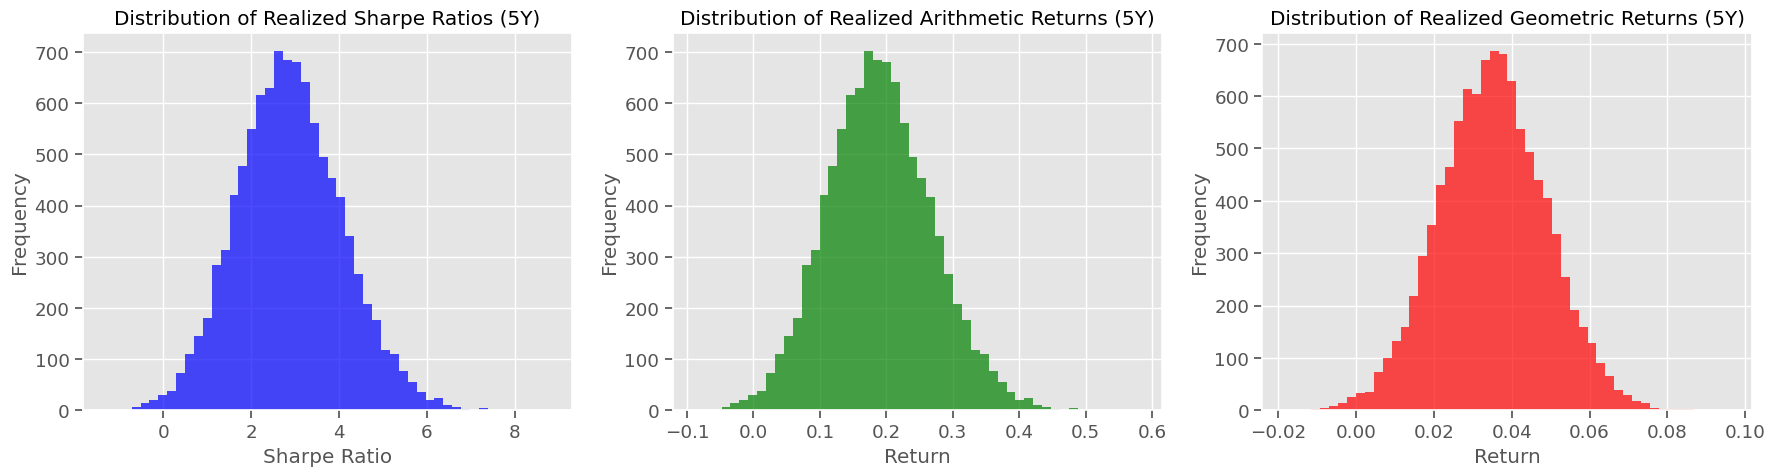

Summary Statistics & Distribution Analysis Completed


In [153]:
# Create DataFrame for summary statistics
summary_statistics = pd.DataFrame({
    "Mean": {key: np.mean(values) for key, values in simulation_results.items()},
    "Median": {key: np.median(values) for key, values in simulation_results.items()},
    "Std Dev": {key: np.std(values) for key, values in simulation_results.items()},
    "Min": {key: np.min(values) for key, values in simulation_results.items()},
    "Max": {key: np.max(values) for key, values in simulation_results.items()},
})

# Display summary statistics
print("Summary Statistics for 5-Year Monte Carlo Simulation:")
display(summary_statistics)

# Plot distributions of realized Sharpe ratios, arithmetic, and geometric returns
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Sharpe Ratio Distribution
axes[0].hist(simulation_results["Realized Sharpe Ratios"], bins=50, color='blue', alpha=0.7)
axes[0].set_title("Distribution of Realized Sharpe Ratios (5Y)")
axes[0].set_xlabel("Sharpe Ratio")
axes[0].set_ylabel("Frequency")

# Arithmetic Return Distribution
axes[1].hist(simulation_results["Realized Arithmetic Returns"], bins=50, color='green', alpha=0.7)
axes[1].set_title("Distribution of Realized Arithmetic Returns (5Y)")
axes[1].set_xlabel("Return")
axes[1].set_ylabel("Frequency")

# Geometric Return Distribution
axes[2].hist(simulation_results["Realized Geometric Returns"], bins=50, color='red', alpha=0.7)
axes[2].set_title("Distribution of Realized Geometric Returns (5Y)")
axes[2].set_xlabel("Return")
axes[2].set_ylabel("Frequency")

# Display the plots
plt.tight_layout()
plt.show()

print("Summary Statistics & Distribution Analysis Completed")